In [1]:
#Necessary Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
#import the data
data = pd.read_csv('2020-train.csv')
df = pd.read_csv('2020-test.csv')

In [3]:
#Create Mapping to numerals for mapping into the model as well as color coding for graph
sMapping = {'InPlay': 1, 'BallCalled': 0, 'StrikeCalled' : 1, 'StrikeSwinging' : 1, 'FoulBall': 1, 'HitByPitch': 0, 'BallIntentional': 0}
cMapping = {'InPlay': 'black', 'BallCalled': 'blue', 'StrikeCalled' : 'red', 'StrikeSwinging' : 'orange', 'FoulBall': 'black', 'HitByPitch': 'purple', 'BallIntentional': 'green'}
sides = {'Right' : 0, 'Left': 1}

In [4]:
#create a second df for the edited version and replace blanks or infinites with placeholder figure for modelling
data2 = data.replace([np.inf, -np.inf], np.nan)

#map out the numerics for handedness
data2.pitcher_side = list(data2['pitcher_side'].map(sides))
data2.batter_side = list(data2['batter_side'].map(sides))

# fill nas with placeholder figure for modelling
data2 = data2.fillna(999)

In [5]:
## Note that, with an ongoing project, I would attempt to impute the missing values from available data
## There are some for catcher/umpire value '9c6cbb5e' where no real imputing could be done due to what would appear to be equipment errors.
## For the others, a K nearest neighbor filler would be an effective strategy to determine values for these values.
## I would attempt to find similar pitches and replace the missing values with averages from similar pitches.
## Also, someone with better physics knowledge than I have could potentially calculate the missing values empirically.
## This would likely improve the accuracy of the model.

In [6]:
#add is_strike column
data2['is_strike'] = list(data2['pitch_call'].map(sMapping))

Text(0.5, 1.0, 'Strike Zone')

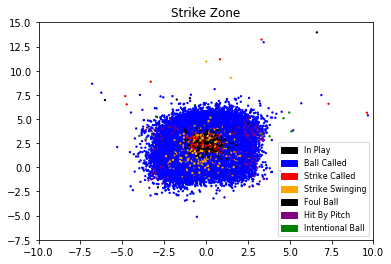

In [7]:
#Plot the pitches and color code by call
plt.scatter(data2.plate_side, data2.plate_height, c=list(data2['pitch_call'].map(cMapping)), s=1.75)

#Create patches which can be imported to label the legend
inPlay = mpatches.Patch(color='black',label='In Play')
Ball = mpatches.Patch(color='blue', label='Ball Called')
calledStrike = mpatches.Patch(color='red',label='Strike Called')
swingStrike = mpatches.Patch(color='orange', label='Strike Swinging')
foulBall = mpatches.Patch(color='black',label='Foul Ball')
HBP = mpatches.Patch(color='purple', label='Hit By Pitch')
intBall = mpatches.Patch(color='green',label='Intentional Ball')

#Use the patches to create a legend, add title, set limits
plt.xlim((-10,10))
plt.ylim((-7.5,15))
plt.legend(handles=[inPlay, Ball, calledStrike, swingStrike, foulBall, HBP, intBall], prop={'size': 8})
plt.title("Strike Zone")

#side note - This graph turned out to not be very helpful but I still like to graph my data to make sure it doesn't look wrong

In [8]:
#put all of the potentially relevant data points into a test and train series
X = data2[['pitcher_side', 'batter_side', 'outs', 'balls', 'strikes',
       'release_speed', 'vert_release_angle', 'horz_release_angle',
       'spin_rate', 'spin_axis', 'rel_height', 'rel_side', 'extension',
       'vert_break', 'induced_vert_break', 'horz_break', 'plate_height',
       'plate_side', 'zone_speed', 'vert_approach_angle',
       'horz_approach_angle', 'zone_time', 'x55', 'z55']]
y = data2.is_strike
# Random state of 116 with a nod to 2001
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=116)

In [9]:
#load a random forest classifier to model the outcomes
rf = RandomForestClassifier()

In [10]:
#fit the model to the training data
rf = rf.fit(X_train, y_train)
#display the scores in and out of sample
print(f'{round(rf.score(X_train, y_train),4)* 100} % in sample.')
print(f'{round(rf.score(X_test, y_test),4)*100} % out of sample.')

#85% out of sample is not too shabby!

C:\Users\Trevor\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


99.19 % in sample.
85.39 % out of sample.


In [11]:
#Examine the feature importance for the random forest model
# Generally used to examine reasonableness
# IN this case, most predictive factors are where the ball is, which seems correct!
[(x[0], x[1]) for x in zip(rf.feature_importances_, X.columns)]

[(0.0012338669698234478, 'pitcher_side'),
 (0.0038229587016144284, 'batter_side'),
 (0.005689162848103713, 'outs'),
 (0.009461041795342733, 'balls'),
 (0.01147036554566501, 'strikes'),
 (0.02171311944424787, 'release_speed'),
 (0.058582903809310305, 'vert_release_angle'),
 (0.04511116356663686, 'horz_release_angle'),
 (0.02242829006585355, 'spin_rate'),
 (0.025813289684257647, 'spin_axis'),
 (0.026378482044115366, 'rel_height'),
 (0.028791759821247986, 'rel_side'),
 (0.022167292792476534, 'extension'),
 (0.02825200816178517, 'vert_break'),
 (0.02311088538303461, 'induced_vert_break'),
 (0.026449503309633887, 'horz_break'),
 (0.19522641643722596, 'plate_height'),
 (0.25473962362726943, 'plate_side'),
 (0.021147195785299777, 'zone_speed'),
 (0.05090645606082993, 'vert_approach_angle'),
 (0.04000384570372763, 'horz_approach_angle'),
 (0.021977241474858723, 'zone_time'),
 (0.030442644118302616, 'x55'),
 (0.025080482849336855, 'z55')]

In [12]:
#create another column for the predictions made by the model
data2['Predictions'] = rf.predict(X)

In [13]:
#Create a logistic regression model to see if it outperforms the random forest regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\Trevor\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [14]:
#Print prediction accuracy based on logistic regression model
# It does not outperform our random forest model
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on train set: 0.66
Accuracy of logistic regression classifier on test set: 0.66


In [15]:
# print the classification report for the logistic regression
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.07      0.13     52964
           1       0.65      0.99      0.79     92588

   micro avg       0.66      0.66      0.66    145552
   macro avg       0.76      0.53      0.46    145552
weighted avg       0.73      0.66      0.55    145552



In [16]:
#complete the same preprocessing for the test data to input into the model
df2 = df.replace([np.inf, -np.inf], np.nan)
df2.pitcher_side = list(df['pitcher_side'].map(sides))
df2.batter_side = list(df['batter_side'].map(sides))
df2 = df2.fillna(999)

In [17]:
X2 = df2[['pitcher_side', 'batter_side', 'outs', 'balls', 'strikes',
       'release_speed', 'vert_release_angle', 'horz_release_angle',
       'spin_rate', 'spin_axis', 'rel_height', 'rel_side', 'extension',
       'vert_break', 'induced_vert_break', 'horz_break', 'plate_height',
       'plate_side', 'zone_speed', 'vert_approach_angle',
       'horz_approach_angle', 'zone_time', 'x55', 'z55']]

In [18]:
df.is_strike = rf.predict(X2)

Text(0.5, 1.0, 'Strike Zone')

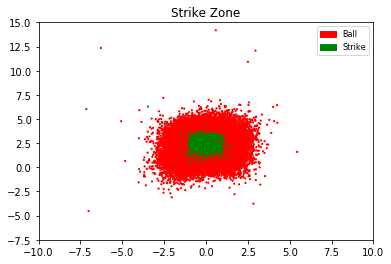

In [22]:
#Plot the pitches and color code by call
fMapping = {0: 'red', 1 : 'green'}
plt.scatter(df.plate_side, df.plate_height, c=list(df['is_strike'].map(fMapping)), s=1.5)

#Create patches which can be imported to label the legend
Ball = mpatches.Patch(color='red', label='Ball')
Strike = mpatches.Patch(color='green',label='Strike')

#Use the patches to create a legend, add title, set limits
plt.xlim((-10,10))
plt.ylim((-7.5,15))
plt.legend(handles=[Ball, Strike], prop={'size': 8})
plt.title("Strike Zone")

## Looking at this graph, we can see that the model seems to make reasonable predictions!

In [20]:
df.to_csv('2020-test-with-answers.csv')